In [1]:
import pandas as pd
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE

import main
import seaborn as sns
drive_path = r"\\NERFHF01/djnerf1/VEIDB/"
# data_path = r"Y:\Data"
data_path =r"W:\Data/"
ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
from datetime import date
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import os
import seaborn as sb
sb.set_style('white')

In [3]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
raw_table_helper = ft.ephys_tables.EphysRawHelper()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

sorted_table = ft.ephys_tables.SpikeSorted()

In [4]:
def smooth_spikecounts(spikecounts, sigma=2):
    return ndimage.gaussian_filter1d(spikecounts, sigma)

def filter_clusters(clusters, cluster_annot, annot=['good']):
    clusters_filtered = {}
    for c in cluster_annot:
        if cluster_annot[c] in annot:
            clusters_filtered[c] = clusters.get(c)
    return clusters_filtered
                

def plot_spike_raster(clusters, start, end, ax, event_times=None, colored=False, color_palette=None, visualize_depth=False, cluster_depths=None):
    data = []

    for c, cl_spike_times in clusters.items():
        if cl_spike_times is not None and isinstance(cl_spike_times, np.ndarray):
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            data.append((c, cl_spike_times_sub))
            
    for i, (cluster, cl_spike_times) in enumerate(data[:]):
        if visualize_depth:
            depth = cluster_depths[cluster]
        else:
            depth = cluster
            
        if colored:
            color = color_palette[random.randint(0, len(color_palette)-1)]
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[color]) # SCATTER PLOT
        else:
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[(0, 0, 0, 0.4)]) # SCATTER PLOT
    
    ax.set_ylabel('depth')
    ax.set_xlabel('time (s)')
    if event_times is not None:
        event_types_and_times = list(zip(*[(i, t) for tup in event_times for (i, t) in enumerate(tup)]))
        event_types = np.array(event_types_and_times[0]) 
        event_times = np.array(event_types_and_times[1])
        event_times_sub = event_times[(event_times >= start) & (event_times < end)]
        event_types_sub = event_types[(event_times >= start) & (event_times < end)]
        for event in event_times_sub:
            ax.axvline(event/30000, ymin=0, ymax=1, c='r', alpha=0.8)
            
def spikes_2_spikecounts(clusters, start, end, binsize=30):
    """Excludes neurons that don't fire"""
    first_spike_time = min([s[0] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    last_spike_time = max([s[-1] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    fr_clusters = {}
    for i, (c, cl_spike_times) in enumerate(clusters.items()):
        if cl_spike_times is not None:
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            fr, _ = np.histogram(cl_spike_times_sub, bins=np.arange(start, end, (30000/1000)*binsize))
            fr_clusters[c] = np.float32(fr)
    return fr_clusters

def plot_spikecounts_mean(fr_clusters, ax, mean=True, event_times=None):
    trial_frs = []
    for j, (c, firing_rate) in enumerate(fr_clusters.items()):
#         axs[i].plot(np.ones_like(firing_rate)*c*1, firing_rate)
        trial_frs.append(firing_rate)
    ax.plot(np.mean(np.array(trial_frs), axis=0))


## Collect neurons across recordings 

In [5]:
def get_spiking_tensor(session_key, stim, before=int(30000*0.1), after=0):    
    subsess_key = {'subsession_type': stim, 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
    cluster_info, clusters = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    clusters_good = [c for c, annot in cluster_info['group'].items() if annot == 'good']
    
    trial_starts, trial_ends = (subsess_events_table & subsess_key).fetch1('trials_starts', 'trials_ends')
    trial_lengths = [e-s for s, e in zip(trial_starts, trial_ends)]
    print("Trial lengths: ", trial_lengths)

    n_trials, n_neurons, window_size = len(trial_starts), len(clusters_good), int(max(trial_lengths)+before+after)  
    spiking_tensor = np.zeros(shape=(n_trials, n_neurons, window_size))
    spiking_tensor_meta = np.zeros(shape=(n_neurons))
    for trial_idx, (start, end) in enumerate(zip(trial_starts, trial_ends)):
        for c_idx, c in enumerate(clusters_good):
            c_activity = clusters.get(c, None)
            if c_activity is not None:
                spiking_activity = c_activity[(c_activity >= start-before) & (c_activity < end+after)] - start - before
#                 print(spiking_activity)
                spiking_tensor[trial_idx, c_idx, spiking_activity] = 1
            spiking_tensor_meta[c_idx] = c
    
    return spiking_tensor, spiking_tensor_meta

def get_fr_tensor(subsess_key, before=int(30000*0.1), after=0, binsize=25):
    cluster_info, clusters = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    clusters_good = [c for c, annot in cluster_info['group'].items() if annot == 'good']
    
    trial_starts, trial_ends = (subsess_events_table & subsess_key).fetch1('trials_starts', 'trials_ends')
    trial_lengths = [e-s for s, e in zip(trial_starts, trial_ends)]
    print("Trial lengths: ", trial_lengths)

    n_trials, n_neurons, window_size = len(trial_starts), len(clusters_good), int(max(trial_lengths)+before+after)  
    n_bins = int((window_size*1000)/(30000*binsize))
    fr_tensor = np.zeros(shape=(n_trials, n_neurons, n_bins))
    fr_tensor_meta = np.zeros(shape=(n_neurons))
    for trial_idx, (start, end) in enumerate(zip(trial_starts, trial_ends)):
        for c_idx, c in enumerate(clusters_good):
            c_activity = clusters.get(c, None)
            if c_activity is not None:
                spiking_activity = c_activity[(c_activity >= start-before) & (c_activity < end+after)]
                fr, _ = np.histogram(spiking_activity, bins=np.arange(start-before, end+after, (30000/1000)*binsize))
#                 print(fr)
                fr_tensor[trial_idx, c_idx, :len(fr)] = smooth_spikecounts(fr, sigma=0.5)
            fr_tensor_meta[c_idx] = c
    
    return fr_tensor, fr_tensor_meta


In [6]:
sess_table.fetch()

array([('01230', 'M01', '20200326a', datetime.date(2020, 3, 26)),
       ('01231', 'M01', '20200327a', datetime.date(2020, 3, 27)),
       ('01232', 'M01', '20200328a', datetime.date(2020, 3, 28)),
       ('01233', 'M01', '20200329a', datetime.date(2020, 3, 29)),
       ('01247', 'M01', '20200328e', datetime.date(2020, 3, 28)),
       ('01254', 'M01', '20200303a', datetime.date(2020, 3, 3)),
       ('01261', 'M01', '20200327f', datetime.date(2020, 3, 27)),
       ('01437', 'M02', '20201214', datetime.date(2020, 12, 14))],
      dtype=[('experiment_id', 'O'), ('mouse_id', 'O'), ('session_id', 'O'), ('session_date', 'O')])

In [8]:
# sessions = [{'experiment_id': '01230', 'session_id': '20200326a'}, {'experiment_id': '01231', 'session_id': '20200327a'}, {'experiment_id': '01232', 'session_id': '20200328a'}]
sessions = [{'experiment_id': '01231', 'session_id': '20200327a'}, {'experiment_id': '01232', 'session_id': '20200328a'}, {'experiment_id': '01261', 'session_id': '20200327f'}, {'experiment_id': '01247', 'session_id': '20200328e'}]
sessions_sSC_depths = [(1900, 2250), (2100, 2450), (2250, 2550), (2800, 3100)]

In [9]:
figures_folder = os.path.join(r"C:\Users\bramn\Documents\Projects\DatajointVEIDB\images\clustering")
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)
    
stims_vis = ['EXPA', 'DIMM', 'CHPE', 'EXPW']



In [10]:
def load_session(session_key):
    stims_dict = {}
    for stim in stims_vis:
        stims_dict[stim] = {}
        subsess_key = session_key
        subsess_key['subsession_type'] = stim
        fr_tensor, fr_tensor_meta = get_fr_tensor(subsess_key, binsize=30)
        subsess_key = {'subsession_type': stim, 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
        stims_dict[stim]['key'] = subsess_key
        stims_dict[stim]['fr_tensor'] = fr_tensor
        stims_dict[stim]['fr_tensor_meta'] = fr_tensor_meta
    return stims_dict
        
sessions_list = []
for sess in sessions:
    sessions_list.append(load_session(sess))

# padding = 0
# binsize = 25
# smooth_sigma = 1
# n_trials = 4 

# spiking_tensor, spiking_tensor_meta = get_spiking_tensor(sessions[0], 'EXPA')
# fr_tensor, fr_tensor_meta = get_fr_tensor(sessions[0], 'DIMM')

Trial lengths:  [24999, 24995, 25000, 24995, 25001, 25001, 25000, 25001, 25000, 24999]
Trial lengths:  [24996, 25000, 25000, 25007, 25002, 25000, 25000, 25000, 24995, 25000]
Trial lengths:  [962490, 962502, 962494, 962494, 962494, 962495, 962495, 962496, 962500, 962491]
Trial lengths:  [24995, 24991, 24994, 24999, 25002, 24999, 25000, 25005, 25001, 25000]
Trial lengths:  [25000, 24988, 25000, 25000, 24998, 25008, 25000, 25000, 25001, 25002]
Trial lengths:  [25001, 25001, 24999, 25002, 25007, 24996, 25001, 25000, 25001, 25000]
Trial lengths:  [962496, 962496, 962496, 962496, 962495, 962495, 962495, 962494, 962494, 962494]
Trial lengths:  [25000, 24999, 24994, 25000, 25000, 25000, 25000, 24993, 25001, 24994]
Trial lengths:  [24999, 24999, 25001, 25001, 25000, 25001, 25001, 25000, 25000, 25004]
Trial lengths:  [25002, 25001, 24994, 24996, 25001, 24999, 25000, 25000, 24998, 25000]
Trial lengths:  [962498, 962495, 962495, 962494, 962494, 962494, 962496, 962495, 962497, 962500]
Trial lengths

In [11]:
EXPA_fr_list = []
DIMM_fr_list = []
CHPE_fr_list = []
EXPW_fr_list = []
relat_depth_list = []
for sess, (sSC_begin, sSC_end) in zip(sessions_list, sessions_sSC_depths):
    cluster_info = (sorted_table & sess['EXPA']['key']).fetch1('cluster_info')
    
    """ Might contain a bug!! Check!"""
    cluster_depths = np.array(list(map(lambda x: cluster_info['depth'][x], sess['EXPA']['fr_tensor_meta'])))
    sorted_idxs = np.argsort(cluster_depths)
    sSC_filter = ((cluster_depths >= sSC_begin) & (cluster_depths <= sSC_end))[sorted_idxs]
    sSC_idxs = sorted_idxs[sSC_filter]
    
    EXPA_fr_list.append(sess['EXPA']['fr_tensor'][:,sSC_idxs,:])
    DIMM_fr_list.append(sess['DIMM']['fr_tensor'][:,sSC_idxs,:])
    CHPE_fr_list.append(sess['CHPE']['fr_tensor'][:,sSC_idxs,:])
    EXPW_fr_list.append(sess['EXPW']['fr_tensor'][:,sSC_idxs,:])
    relat_depth_list.append(cluster_depths[sSC_idxs]-sSC_begin)
    
# EXPA_fr = np.concatenate([sess['EXPA']['fr_tensor'] for sess in sessions_list], axis=1)
# DIMM_fr = np.concatenate([sess['DIMM']['fr_tensor'] for sess in sessions_list], axis=1)
# CHPE_fr = np.concatenate([sess['CHPE']['fr_tensor'] for sess in sessions_list], axis=1)
EXPA_fr = np.concatenate(EXPA_fr_list, axis=1)
DIMM_fr = np.concatenate(DIMM_fr_list, axis=1)
CHPE_fr = np.concatenate(CHPE_fr_list, axis=1)
EXPW_fr = np.concatenate(EXPW_fr_list, axis=1)
relat_depth = np.concatenate(relat_depth_list)

In [12]:
relat_depth_sorted_idxs = np.argsort(relat_depth)
EXPA_fr = EXPA_fr[:,relat_depth_sorted_idxs]
DIMM_fr = DIMM_fr[:,relat_depth_sorted_idxs]
CHPE_fr = CHPE_fr[:,relat_depth_sorted_idxs]
EXPW_fr = EXPW_fr[:,relat_depth_sorted_idxs]

In [13]:
[fr.shape for fr in EXPA_fr_list]

[(10, 10, 31), (10, 20, 31), (10, 33, 31), (10, 21, 31)]

In [14]:
np.all(sessions_list[1]['EXPA']['fr_tensor_meta'] == sessions_list[1]['DIMM']['fr_tensor_meta'])

True

In [15]:
EXPA_fr.shape

(10, 84, 31)

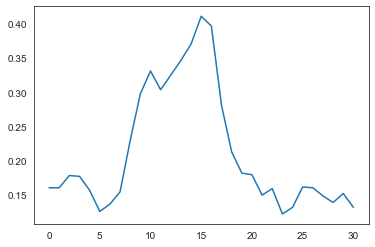

In [16]:
plt.plot(np.mean(DIMM_fr, axis=(0,1)))
# plt.plot(fr_tensor[0,0,:])
plt.show()

In [17]:
fr_comb = np.concatenate([np.mean(EXPA_fr[:], axis=0), np.mean(DIMM_fr[:], axis=0), np.mean(EXPW_fr[:], axis=0)], axis=1)
# fr_comb = np.concatenate([np.mean(EXPA_fr[:], axis=0), np.mean(DIMM_fr[:], axis=0), np.mean(CHPE_fr[:], axis=0)], axis=1)

In [18]:
def plot_corrmatrix(fr_matrix, filename):
    corr_matrix = np.corrcoef(fr_matrix)
    """ Remove NaN entries"""
    corr_matrix = corr_matrix[:, ~np.all(np.isnan(corr_matrix), axis=0)]
    corr_matrix = corr_matrix[~np.all(np.isnan(corr_matrix), axis=1), :]

    print(corr_matrix.shape)
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    sb.heatmap(corr_matrix, annot=False, square=True, ax=ax)
    ax.set_xlabel('sSC neurons')
    ax.set_ylabel('sSC neurons')
    plt.savefig(filename, dpi=150)

c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(79, 79)


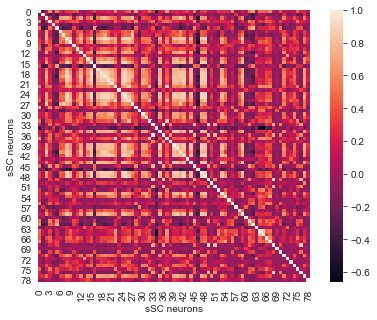

In [19]:
plot_corrmatrix(fr_comb, 'images\sSC_neurons_corrmat_depthsorted_grpchpe.png')

In [20]:
# dim reduction on each stimulus + average over trials + concatenate traces 

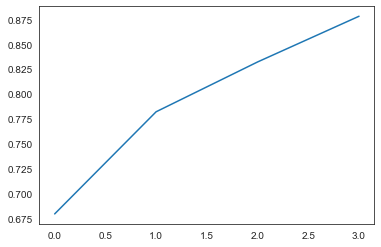

In [21]:
""" Perform PCA on spikes"""
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=4)
pca.fit(fr_comb)
embeddings = pca.transform(fr_comb)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(79, 79)


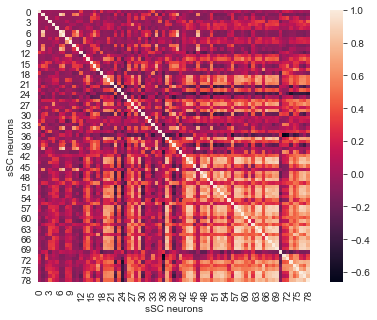

In [22]:

plot_corrmatrix(fr_comb[np.argsort(embeddings[:,0])], 'images\sSC_neurons_corrmat_pc0sorted2_grpchpe.png')

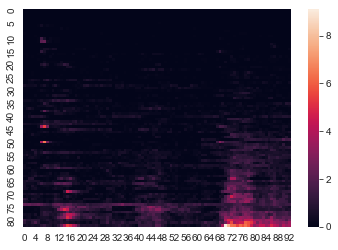

In [23]:
""" Sorted based on first PC"""
sb.heatmap(fr_comb[np.argsort(embeddings[:,0])])

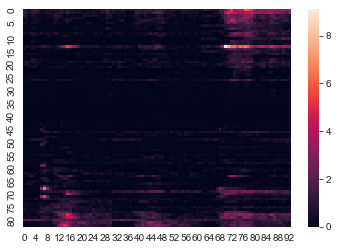

In [24]:
""" Sorted based on second PC"""
sb.heatmap(fr_comb[np.argsort(embeddings[:,1])])

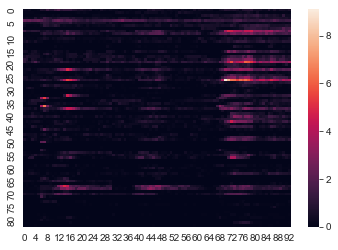

In [25]:
""" Sorted based on depth """
sb.heatmap(fr_comb)

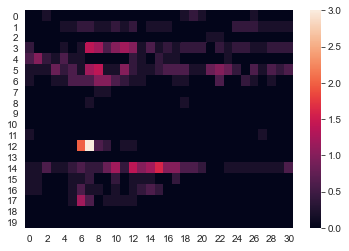

In [27]:
""" Heatmap for a specific experiment"""
sb.heatmap(np.mean(EXPA_fr_list[-1][:5], axis=0)[np.argsort(relat_depth_list[1])])

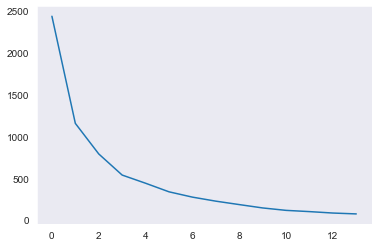

In [60]:
# ELBOW method for deciding K in K-means
import sklearn.cluster

ssqs = []
for k in range(1, 15):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    kmeans.fit(embeddings)
    ssqs.append(kmeans.inertia_)
    
plt.plot(ssqs)

In [61]:
kmeans = sklearn.cluster.KMeans(n_clusters=4, init='k-means++', max_iter=1000)
kmeans.fit(embeddings)

KMeans(max_iter=1000, n_clusters=4)

In [62]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=4)
clusterer.fit(embeddings)

HDBSCAN(min_cluster_size=4)

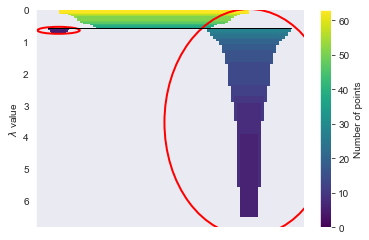

In [63]:
clusterer.condensed_tree_.plot(cmap='viridis', select_clusters=True)

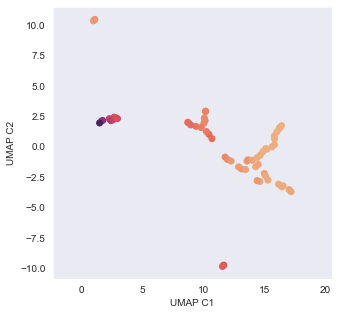

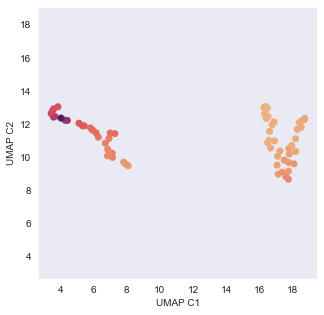

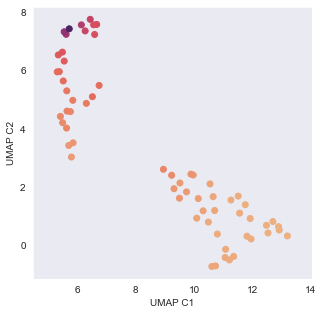

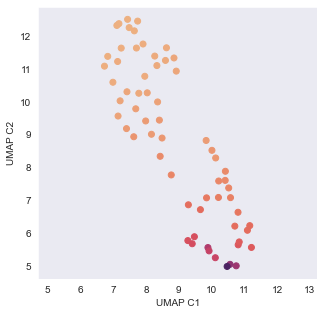

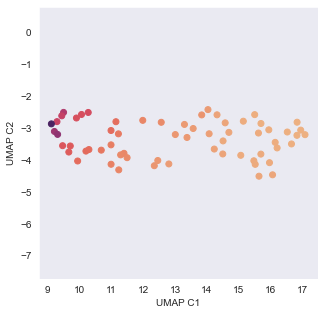

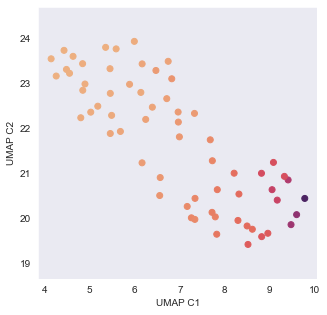

In [64]:
import umap




for n in (3, 5, 7, 12, 15, 40):
    reducer = umap.UMAP(n_neighbors=n)
    umap_embedding = reducer.fit_transform(embeddings)

    """ 2d plot"""
    plt.figure(figsize=(3, 3))
    plt.scatter(
        umap_embedding[:, 0],
        umap_embedding[:, 1], c='gray', cmap='flare') # c=embeddings[:,0]
    plt.xlabel('UMAP C1')
    plt.ylabel('UMAP C2')
    plt.gca().set_aspect('equal', 'datalim')
    # plt.title('PCA of mouse SC activity during looming stimuli', fontsize=14)
    # plt.savefig('images\ssc_pc1_umap2_grpchpe.png', dpi=150)
    plt.show()

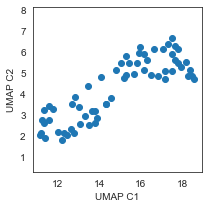

In [113]:
reducer = umap.UMAP(n_neighbors=12)
umap_embedding = reducer.fit_transform(embeddings)

""" 2d plot"""
plt.figure(figsize=(3, 3))
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],  cmap='flare') # c=embeddings[:,0]
plt.xlabel('UMAP C1')
plt.ylabel('UMAP C2')
plt.gca().set_aspect('equal', 'datalim')
# plt.title('PCA of mouse SC activity during looming stimuli', fontsize=14)
plt.tight_layout()
plt.savefig('images\ssc_pc1_umap2_grpchpe.png', dpi=150)
plt.show()

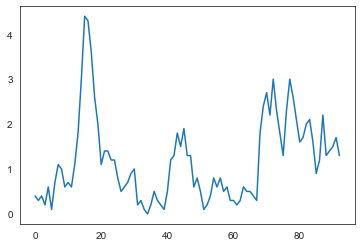

In [106]:
# item1_idx = np.argsort(umap_embedding[:,0])
plt.plot(fr_comb[30])
plt.show()

In [80]:
item1_idx

array([20,  4, 12, 30, 17,  5, 55, 18, 34, 52, 16,  1, 40,  8, 33, 25, 13,
       54, 43, 44, 38, 28, 19, 49,  0, 36,  2, 32, 14, 15,  3, 26, 31,  6,
       21, 42, 27, 37, 29, 35, 24, 46, 39, 50, 47, 41, 60, 48, 53, 56, 11,
        7, 61, 22, 51, 59, 23, 57, 10, 62, 45, 58,  9], dtype=int64)

In [31]:
np.unique(clusterer.labels_, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([28,  7, 28], dtype=int64))

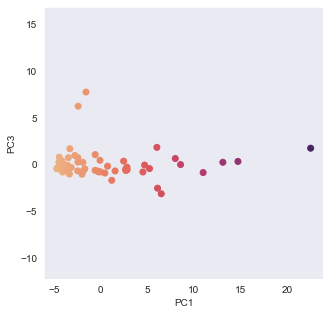

In [32]:
plt.figure(figsize=(5, 5))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 2], c=embeddings[:,0], cmap='flare')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.gca().set_aspect('equal', 'datalim')
# plt.title('PCA of mouse SC activity during looming stimuli', fontsize=14)
plt.savefig('images\ssc_pca2_grp.png', dpi=150)
plt.show()

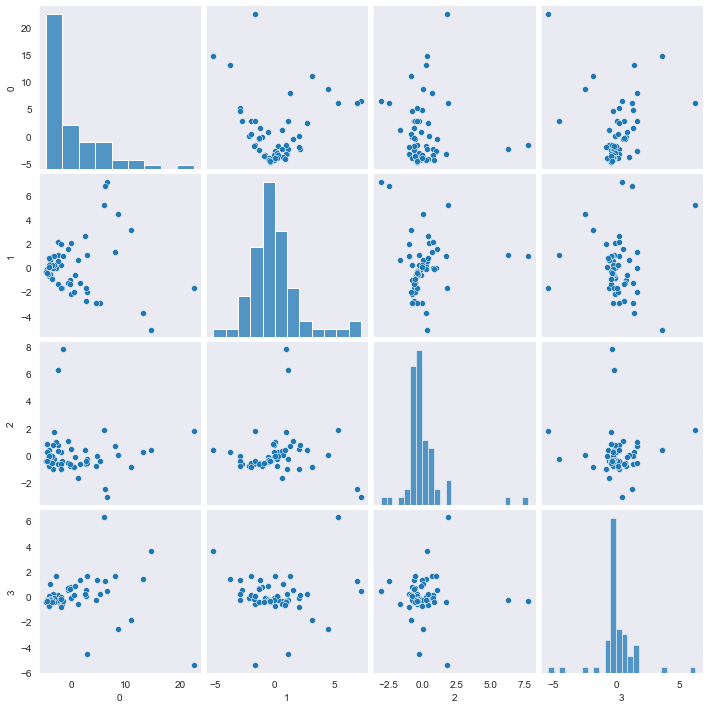

In [33]:
sb.pairplot(pd.DataFrame(embeddings))
plt.show()

ValueError: shapes (8,) and (4,93) not aligned: 8 (dim 0) != 4 (dim 0)

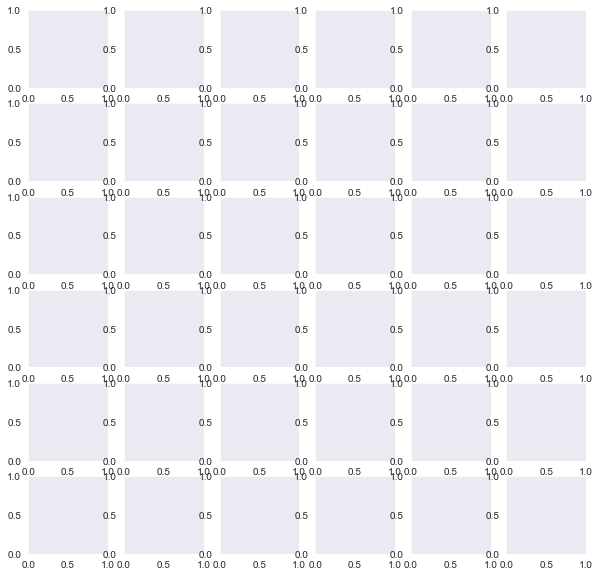

In [34]:
fig, axs = plt.subplots(6, 6, figsize=(10, 10))
for i, pc1 in enumerate(np.linspace(-5, 5, 6)):
    for j, pc2 in enumerate(np.linspace(-5, 5, 6)):
        axs[i][j].plot(pca.inverse_transform([pc1, pc2, 0, 0, 0, 0, 0, 0]))
        axs[i][j].set_title(f"PC1:{pc1}, PC2:{pc2}")
        axs[i][j].set(ylim=[-3, 3])
plt.tight_layout()
plt.savefig('images\PCA_gridvis_grp.png', dpi=150)
plt.show()

In [ ]:
plt.plot(pca.inverse_transform([-2, 0, 1, 1, 1, 1, 1 ,1 ]))

In [ ]:
plt.plot(pca.inverse_transform([0, 1, 0, 0]))

In [ ]:
plt.plot(pca.inverse_transform([1, 0, 0, 0]))

In [ ]:
plt.plot(pca.components_[3])

# ------------------- OLD ----------------------

In [26]:
figures_folder = os.path.join(r"C:\Users\bramn\Documents\Projects\DatajointVEIDB\images\clustering")
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)
    
stims_vis = ['EXPA', 'DIMM', 'CHPE']

    
def load_session(session_key, stims_vis):
    clusters_info = (sorted_table & session_key).fetch1('cluster_info')
    clusters_good = [c for c, annot in cluster_info['group'].items() if annot == 'good']

    stims_dict = {}
    for stim in stims_vis:
        stims_dict[stim] = {}
        stims_dict[stim]['key'] = {'subsession_type': stim, 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
        stims_dict[stim]['clusters'] = (subsess_spikes_table & stims_dict[stim]['key']).fetch1('clusters')
        stims_dict[stim]['starts'], stims_dict[stim]['ends'], stims_dict[stim]['triggers'] = (subsess_events_table & stims_dict[stim]['key']).fetch1('trials_starts', 'trials_ends', 'subsession_triggers')
    
    padding = 0
    binsize = 25
    smooth_sigma = 1
    n_trials = 4 

    for c in clusters_good:
        c_depth = cluster_info['depth'][c]

        for stim, d in stims_dict.items():
            trials = []
            trial_lengths = []
            for start, end in zip(d['starts'], d['ends']):
                spikecounts = spikes_2_spikecounts({c: d['clusters'].get(c, np.array([]))}, start=start-padding, end=end+padding, binsize=binsize)[c]
                trials.append(smooth_spikecounts(spikecounts, sigma=smooth_sigma))
                trial_lengths.append(len(spikecounts))
            min_trial_length = min(trial_lengths)
            stims_dict[stim]['trials'] = trials
            stims_dict[stim]['min_trial_length'] = min_trial_length
            stims_dict[stim]['trials_np'] = np.array([trial[:min_trial_length] for trial in trials]) # Assumes that all trials have the same length!!
    return stims_dict, clusters_good, clusters_info

In [19]:
sessions_dict = {}
for session_key in sessions:
    sessions_dict[session_key['session_id']] = {}
    stims_dict, clusters_good, clusters_info = load_session(session_key, stims_vis)
    sessions_dict[session_key['session_id']]['stims_dict'] = stims_dict
    sessions_dict[session_key['session_id']]['clusters_good'] = clusters_good
    sessions_dict[session_key['session_id']]['clusters_info'] = clusters_info

In [24]:
# Create matrices of all neurons x stimulus time
matrices = []
for stim in stims_vis:
    session_neurons = []
    for key, session in sessions_dict.items():
        session_neurons.append(session['stims_dict'][stim]['trials_np'])
    print(session_neurons[-1].shape)
    matrices.append(np.concatenate(session_neurons, axis=0))


(10, 33)
(10, 33)
(10, 1283)


In [22]:
### Get ~sSC location
matrices[0].shape

(20, 33)

In [264]:
# Order based on depth

fr_tensor_meta = sessions_list[0]['EXPA']['fr_tensor_meta']
cluster_info = (subsess_spikes_table & sessions_list[0]['EXPA']['key']).fetch1('cluster_info')

cluster_depths = np.array(list(map(lambda x: cluster_info['depth'][x], fr_tensor_meta)))
sorted_idxs = np.argsort(cluster_depths)

In [267]:
sSC_idxs = sorted_idxs[(cluster_depths >= 1800) & (cluster_depths <= 2250)]

In [271]:
corr_matrix = np.corrcoef(np.concatenate([np.mean(EXPA_fr[:], axis=0), np.mean(DIMM_fr[:], axis=0), np.mean(CHPE_fr[:], axis=0)], axis=1)[sSC_idxs])

In [272]:
corr_matrix.shape

(17, 17)

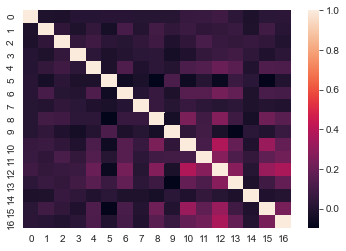

In [273]:
sb.heatmap(corr_matrix, annot = False)